# GenomicSEM for combining GWAS Summary stats
Steps:
1. Munge summary statistics (if necessary from LDSC formatted data)
1. Compute covariance between traits using multivariate LDSC functionality from GenomicSEM 
1. Exploratory factor analysis to learn "appropriate" number of factors to explain all neuropsychiatric trait GWAS
1. Confirmatory factor analysis using GenomicSEM
1. Common factor GWAS with learned hierarchical model

In [2]:
library(data.table)
library(tidyverse)
library(parallel)
library(GenomicSEM)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Warning message:
“replacing previous import ‘gdata::nobs’ by ‘lavaan::nobs’ when loading ‘GenomicSEM’”
Warning message:
“replacing previous import ‘gdata::last’ by ‘data.table::last’ when loading ‘GenomicSEM’”
Warning message:
“replacing previous import ‘gdata::first’ by ‘data.table::first’ when loading ‘GenomicSEM’”
Warning message:
“replacing previous import ‘gdata::env’ by ‘R.utils::env’ when loading ‘Genomic

## Munge Summary statistics


In [3]:
sumstat_files <-c("/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/adhd_jul2017.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/anxiety.meta.full.cc.tbl.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/AUDIT_UKB_2018_AJP_fixed.txt.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/Cannabis_ICC_23andmetop_UKB_het_fixed.txt.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/iPSYCH-PGC_ASD_Nov2017.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/ocd_aug2017.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/pgc_alcdep.trans_fe_unrel_geno.aug2018_release.txt.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/pgc_bip_2018.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/PGC_UKB_depression_genome-wide_fixed.txt.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/PGC3_SCZ_wave3_public.v2.tsv.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/tag.cpd.tbl.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/TS_Oct2018.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/pts_all_freeze2_overall.results.gz",
            "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_sumstats/opioid-exposed_vs._opioid-unexposed_controls_in_the_trans-ancestry_meta-analysis_fixed.gz"
)
sample_sizes <-c(55374,17310,141932,184765,46351,9725,34556,198882,500199,161405,74053,14307,64357,8592)
trait_names <- c("ADHD", "ANX", "AUDIT","CUD","ASD","OCD","ALC","BIP","MDD","SCZ","TAG_CPD","TS","PTSD","OD")
# munge(sumstat_files,hm3 = "/scratch/st-dennisjk-1/wcasazza/w_hm3.snplist",N=sample_sizes,trait.names = trait_names)

## Compute covariances using multivariate LDSC
Combined vs sex-biased. **RERUN WITH STAND ARGUMENT TO GET GENETIC CORRELATION**

In [7]:
traits <- paste0(trait_names,".sumstats.gz")
# dir("/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats",pattern = "(ASD_Nov|depression|tag|adhd_jul|AUDIT|bip|SCZ|TS|ocd|anxiety.meta.full.cc|Cannabis_ICC|pgc_alcdep.trans).*.gz",full.names = TRUE)# filter these
# paste0('"',traits,'"', collapse=",")
sample_prev <- c(0.36, 0.33, NA,0.30,0.40,0.28,0.33,0.15,0.34,0.42,NA,0.34,0.15,0.52)#Sample prevalence
population_prev <-c(0.094,0.19,NA,0.16,0.019,0.012,0.053,0.028,0.071,0.0075,NA,0.0089,0.068,0.011) #Population prevalence
ld <- "/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/weights_1kg_common/"#non-partitioned ldscores dir
wld <- "/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/weights_1kg_common/"#unweighted ld scores dir, in tutorial is the same as above
LDSCoutput <- ldsc(traits=traits, sample.prev=sample_prev, population.prev=population_prev, ld=ld, wld=wld, trait.names=trait_names)

List of 5
 $ V: num [1:105, 1:105] 1.85e-04 -1.18e-05 1.10e-05 4.16e-06 4.70e-05 ...
 $ S: num [1:14, 1:14] 0.16476 0.01467 0.00591 0.013 0.03697 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:14] "ADHD" "ANX" "AUDIT" "CUD" ...
 $ I: num [1:14, 1:14] 1.11841 0.01909 0.00492 0.0082 0.38494 ...
 $ N: num [1, 1:105] 55374 29383 81731 93665 50662 ...
 $ m: num 7789042


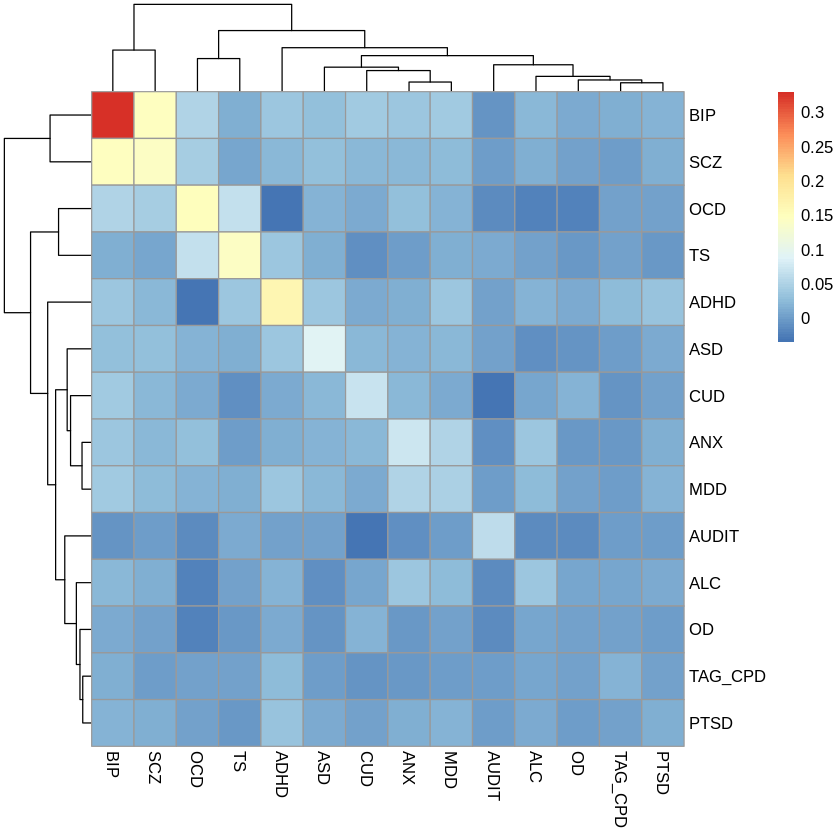

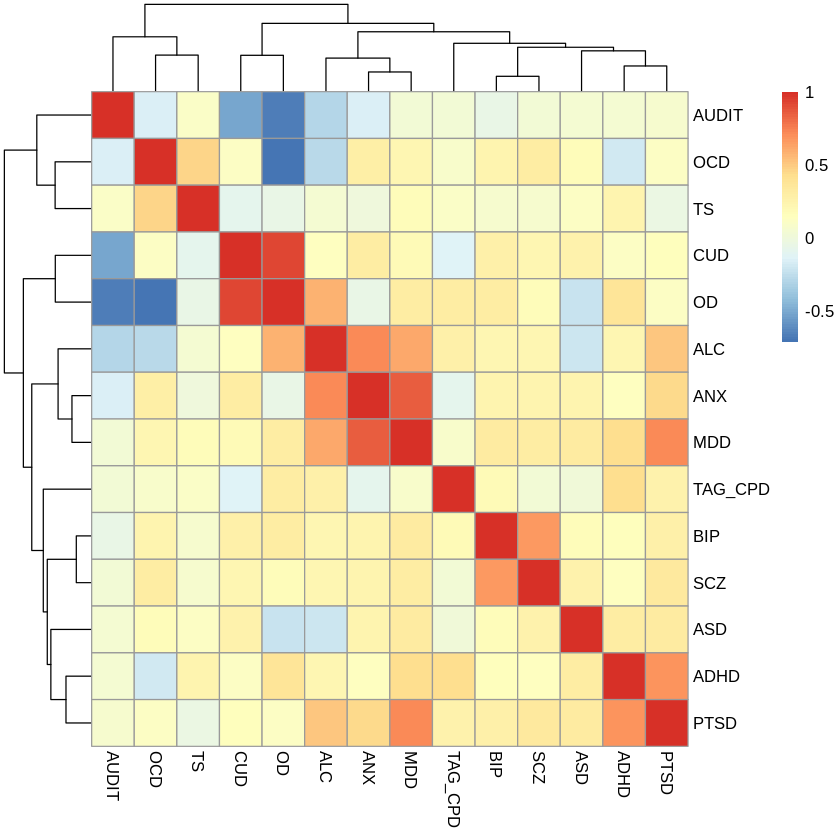

In [5]:
library(pheatmap)
if(!file.exists("../data/LDSC_covariances.RDS")){
    saveRDS(LDSCoutput,"../data/LDSC_covariances.RDS")
}else{
    LDSCoutput <- readRDS("../data/LDSC_covariances.RDS")
}
str(LDSCoutput)

cov_to_plot <- LDSCoutput$S
rownames(cov_to_plot) <- colnames(LDSCoutput$S)

genetic_corr <- fread("genetic_correlation_genomicSEM.txt")
cor_to_plot <- as.matrix(dcast(genetic_corr,Var1~Var2)[,-c(1)])
rownames(cor_to_plot) <- colnames(cor_to_plot)
pheatmap(cov_to_plot)
pheatmap(cor_to_plot)

## Common factor GWAS

In [8]:
se_logit <- c(
    T,
    T,
    F,
    T,
    T,
    T,
    T,
    T,
    T,
    T,
    F,
    T,
    T,
    T
)

ols <- c(
    F,
    F,
    T,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    T,
    F,
    F,
    F
)
linprob <- c(
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    F,
    T
)
p_sumstats <-sumstats(
    files=sumstat_files,
    ref="../../reference.1000G.maf.0.005.txt",
    trait.names=trait_names,
    se.logit=se_logit,
    OLS=ols,
    linprob=linprob,
    prop=sample_prev,
    N=sample_sizes,
    info.filter=0.6,
    maf.filter=0.01,
    keep.indel=FALSE,
    parallel=T,
    cores=8)

[1] "Please note that the files should be in the same order that they were listed for the ldsc function."
[1] "Reading in reference file"
[1] "Applying MAF filer of 0.01 to the reference file."
[1] "Performing conversions of individual summary statistics using parallel processing. Please note this step typically takes 10-20 minutes due to the size of the files."
[1] "After merging across all summary statistics using listwise deletion, performing QC, and merging with the reference file, there are 1982138 SNPs left in the final multivariate summary statistics file"
[1] "Sumstats finished running at 2021-05-06 11:22:32"
[1] "Running sumstats for all files took 6 minutes and 52.4922862052917 seconds"
[1] "Please check the log files to ensure that all columns were interpreted correctly and no warnings were issued for any of the summary statistics files."


In [11]:
if(!file.exists("common_factor_sumstats_14_traits.txt.gz")){
    fwrite(p_sumstats,"common_factor_sumstats_14_traits.txt.gz",sep='\t',quote=F,row.names=F)
}else{
    p_sumstats <- fread("common_factor_sumstats_14_traits.txt.gz")
}
head(p_sumstats)

SNP,CHR,BP,MAF,A1,A2,beta.ADHD,se.ADHD,beta.ANX,se.ANX,⋯,beta.SCZ,se.SCZ,beta.TAG_CPD,se.TAG_CPD,beta.TS,se.TS,beta.PTSD,se.PTSD,beta.OD,se.OD
<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs3131968,1,754192,0.128231,A,G,0.0177500141,0.011632630,0.018248307,0.03798515,⋯,-0.0036952272,0.006505671,0.006602109,0.007771708,0.005622336,0.04068793,0.011139174,0.009427593,-0.02645988,0.01898497
rs2980319,1,777122,0.123260,A,T,0.0178621228,0.012404472,-0.014223974,0.03429191,⋯,-0.0012142596,0.006891610,0.007430377,0.007904369,0.039137242,0.04266579,0.014226284,0.009592913,-0.02049087,0.01927717
rs4040617,1,779322,0.118290,A,G,-0.0157648228,0.012735367,0.005347874,0.04090848,⋯,0.0006061285,0.007001877,-0.007667623,0.008045940,-0.040460669,0.04294119,-0.017641714,0.009703074,0.02361538,0.01958927
rs2977612,1,780785,0.125249,T,A,0.0108626003,0.012294475,-0.020563615,0.03324359,⋯,-0.0051847258,0.006560795,0.007436339,0.007850265,0.016980671,0.04212020,0.007498062,0.009537931,-0.03351934,0.01958670
rs2905062,1,785050,0.125249,G,A,0.0105309560,0.012239353,-0.018854714,0.03230661,⋯,-0.0058418256,0.006450524,0.006789604,0.007850265,0.009041572,0.04201089,0.011136497,0.009758389,-0.04392497,0.01923425
rs11240777,1,798959,0.204771,G,A,-0.0002755956,0.009482857,-0.020563152,0.03517236,⋯,0.0097596845,0.005513203,-0.008894218,0.006439221,-0.008322485,0.02194264,-0.012843698,0.008214580,0.03001358,0.01583878


## Common factor GWAS

In [ ]:
pfactor <- commonfactorGWAS(covstruc = LDSCoutput, SNPs = p_sumstats)

This is lavaan 0.6-8
lavaan is FREE software! Please report any bugs.

